# VAR 코로나 전후 현황 분석 

## 주가 데이터 다운로드  및 탐색

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm


import warnings
warnings.filterwarnings("ignore")

In [2]:
#전처리 함수 
def preprocess_(path,  column_, slice='',  encoding=None, header='infer'):

    df = pd.read_csv(path, encoding=encoding, header=header)
    
    if slice:
        df = df[slice]

    df.columns = column_

    if (type(df.iloc[:,1][1])==str):
        df.iloc[:,1] = df.iloc[:,1].apply(lambda x: float(x.replace(',', '')))
        
    df['Date'] = df['Date'].str.replace('[^0-9]', '')
    df['Date'] = df['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
    df['Date'] = pd.to_datetime(df['Date'])

    df.sort_values('Date', inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    return df

## VAR 해보기 

 참고 : https://github.com/cheonbi/All-About-Time-Series-Analysis/blob/master/Lecture4_Algorithms_TimeSeries_Linear_Multivariate_KK.ipynb 

 https://sosoeasy.tistory.com/399 

- 기간 2020 2. 18 ~ 2020. 7. 31 (train: test  = 8 : 2)

- 변수 
    - KS200  - 파이넌스데이터리더
    - 환율
    - 유가 (WTI)
    - VIX - 미국변동성지수
    - 금

In [3]:
# 데이터 불러오기 
KS200 = fdr.DataReader('KS200', '2020-1-19', '2020-7-31')
VIX = fdr.DataReader('VIX', '2020-1-19', '2020-7-31')
Exchange = fdr.DataReader('USD/KRW', '2020-1-19', '2020-7-31')
Gold = fdr.DataReader('ZG', '2020-1-19', '2020-7-31')

In [4]:
df_list = [KS200['Close'], VIX['Close'], Exchange['Close'], Gold['Close']]
df_list

[Date
 2020-01-20    305.58
 2020-01-21    302.11
 2020-01-22    306.08
 2020-01-23    302.33
 2020-01-28    292.77
                ...  
 2020-07-27    293.51
 2020-07-28    300.13
 2020-07-29    301.25
 2020-07-30    301.85
 2020-07-31    299.32
 Name: Close, Length: 134, dtype: float64,
 Date
 2020-01-21    12.85
 2020-01-22    12.91
 2020-01-23    12.98
 2020-01-24    14.56
 2020-01-27    18.23
               ...  
 2020-07-27    24.74
 2020-07-28    25.44
 2020-07-29    24.10
 2020-07-30    24.76
 2020-07-31    24.46
 Name: Close, Length: 136, dtype: float64,
 Date
 2020-01-20    1158.61
 2020-01-21    1169.01
 2020-01-22    1164.76
 2020-01-23    1168.54
 2020-01-24    1169.20
                ...   
 2020-07-27    1195.57
 2020-07-28    1199.46
 2020-07-29    1189.79
 2020-07-30    1189.62
 2020-07-31    1193.59
 Name: Close, Length: 140, dtype: float64,
 Date
 2020-01-22    1616.5
 2020-01-23    1625.1
 2020-01-24    1632.2
 2020-01-28    1630.0
 2020-01-29    1631.3
           

In [5]:
df = pd.concat(df_list, #objs속성은 리스트 형태로 데이터프레임을 묶어 
	    axis = 1, # 0일 경우 행병합(위아래 합치기) 1일 경우 열병합(좌우로 합치기). Default는 0.
    	join = 'outer', # 'outer'의 경우 outer join, 'inner'의 경우 inner join. Optional.
        ignore_index = False, # True일 경우 기존의 index를 저장하지 않음. Default는 False.
        copy = False, # 복사
        verify_integrity = False # True일 경우 index가 중복되었는 지 확인
        )

In [6]:
#데이터 
y_data= df.loc['2020-02-18':'2020-07-31']
y_train = y_data[:int(0.7*len(y_data))]
y_test = y_data[int(0.7*len(y_data)):]

In [7]:
y_data

,Close,Close,Close,Close
Date,,,,
2020-02-18,297.74,14.83,1190.95,1657.9
2020-02-19,298.33,14.38,1192.50,1666.3
2020-02-20,296.65,15.56,1204.71,1674.8
2020-02-21,292.42,17.08,1206.91,1703.1
2020-02-24,281.02,25.03,1219.08,1730.3
...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9
2020-07-28,300.13,25.44,1199.46,2013.2
2020-07-29,301.25,24.10,1189.79,NaN


In [8]:
y_train.describe()

,Close,Close,Close,Close
count,79.000000,81.000000,83.000000,63.000000
mean,257.377595,39.914074,1219.265783,1711.063492
std,22.287601,15.183569,17.472957,63.582218
min,199.280000,14.380000,1180.500000,1511.800000
25%,245.240000,28.160000,1211.020000,1677.750000
50%,255.440000,35.970000,1220.580000,1727.500000
75%,272.375000,46.700000,1230.715000,1757.550000
max,298.330000,82.690000,1272.500000,1799.600000


In [9]:
y_test.describe()

,Close,Close,Close,Close
count,36.000000,36.000000,36.000000,33.000000
mean,287.479444,29.166667,1201.355000,1863.945455
std,7.197962,3.654431,6.424145,73.281444
min,267.950000,24.100000,1189.620000,1769.800000
25%,282.427500,25.800000,1197.160000,1816.100000
50%,286.735000,28.350000,1201.175000,1861.600000
75%,291.745000,32.197500,1204.945000,1878.900000
max,301.850000,36.090000,1215.410000,2034.400000


In [10]:
df.columns = ['KS200','VIX','USD/KRW','Gold']
df

,KS200,VIX,USD/KRW,Gold
Date,,,,
2020-01-20,305.58,NaN,1158.61,NaN
2020-01-21,302.11,12.85,1169.01,NaN
2020-01-22,306.08,12.91,1164.76,1616.5
2020-01-23,302.33,12.98,1168.54,1625.1
2020-01-24,NaN,14.56,1169.20,1632.2
...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9
2020-07-28,300.13,25.44,1199.46,2013.2
2020-07-29,301.25,24.10,1189.79,NaN


In [11]:
df.describe()

,KS200,VIX,USD/KRW,Gold
count,134.000000,136.000000,140.000000,106.000000
mean,271.106045,33.624706,1208.733143,1750.935849
std,24.341131,14.730707,20.255602,102.025465
min,199.280000,12.850000,1158.610000,1511.800000
25%,253.957500,25.675000,1193.837500,1680.875000
50%,279.835000,30.880000,1208.980000,1750.650000
75%,290.675000,39.742500,1224.157500,1804.175000
max,306.080000,82.690000,1272.500000,2034.400000


In [12]:
#결측치 확인
df.isnull().sum()

KS200       6
VIX         4
USD/KRW     0
Gold       34
dtype: int64

In [13]:
#결측치는 전날 데이터로 채우기 
df.fillna(method='pad',inplace=True)

In [14]:
df

,KS200,VIX,USD/KRW,Gold
Date,,,,
2020-01-20,305.58,NaN,1158.61,NaN
2020-01-21,302.11,12.85,1169.01,NaN
2020-01-22,306.08,12.91,1164.76,1616.5
2020-01-23,302.33,12.98,1168.54,1625.1
2020-01-24,302.33,14.56,1169.20,1632.2
...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9
2020-07-28,300.13,25.44,1199.46,2013.2
2020-07-29,301.25,24.10,1189.79,2013.2


In [15]:
#필요없는 구간 지우기 
df = df.loc['2020-02-18':'2020-07-31']
df

,KS200,VIX,USD/KRW,Gold
Date,,,,
2020-02-18,297.74,14.83,1190.95,1657.9
2020-02-19,298.33,14.38,1192.50,1666.3
2020-02-20,296.65,15.56,1204.71,1674.8
2020-02-21,292.42,17.08,1206.91,1703.1
2020-02-24,281.02,25.03,1219.08,1730.3
...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9
2020-07-28,300.13,25.44,1199.46,2013.2
2020-07-29,301.25,24.10,1189.79,2013.2


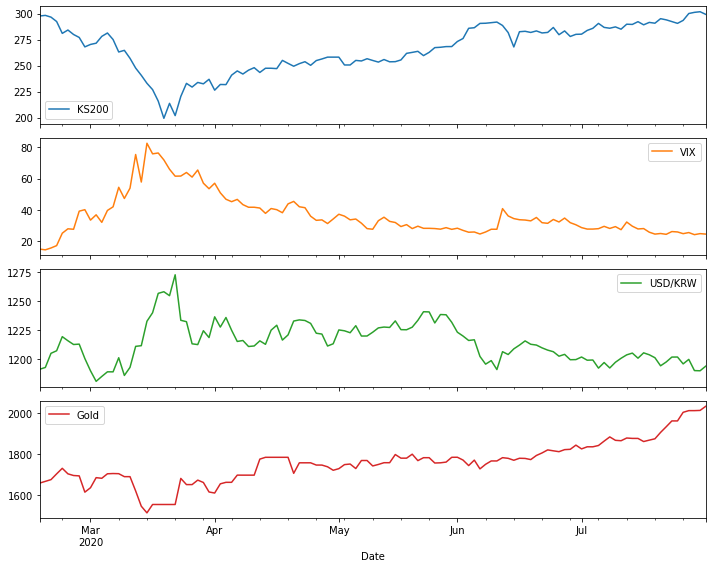

In [16]:
#데이터 시각화 
df.plot(subplots=True, figsize=(10,8))
plt.tight_layout()
plt.show()

<AxesSubplot:>

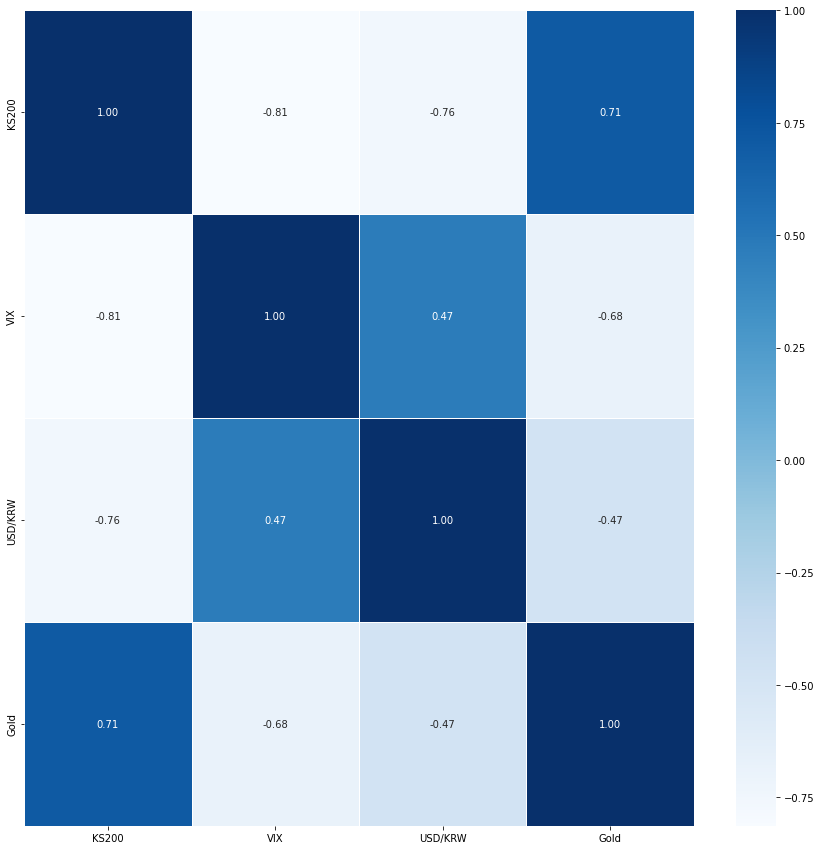

In [17]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

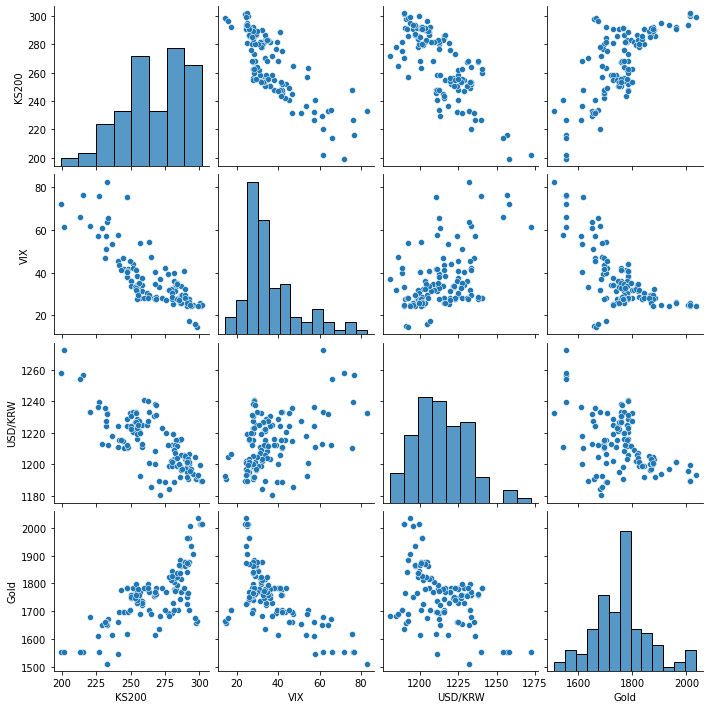

In [18]:
sns.pairplot(df)

In [19]:
# 필요 라이브러리 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

In [20]:
kpss_diffs_ = ndiffs(df['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs_ = ndiffs(df['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs_ = max(adf_diffs_, kpss_diffs_)

print(f"추정된 차수 d = {n_diffs_}")

추정된 차수 d = 1


In [21]:
#로그 
df_log = np.log1p(df)

In [22]:
df

,KS200,VIX,USD/KRW,Gold
Date,,,,
2020-02-18,297.74,14.83,1190.95,1657.9
2020-02-19,298.33,14.38,1192.50,1666.3
2020-02-20,296.65,15.56,1204.71,1674.8
2020-02-21,292.42,17.08,1206.91,1703.1
2020-02-24,281.02,25.03,1219.08,1730.3
...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9
2020-07-28,300.13,25.44,1199.46,2013.2
2020-07-29,301.25,24.10,1189.79,2013.2


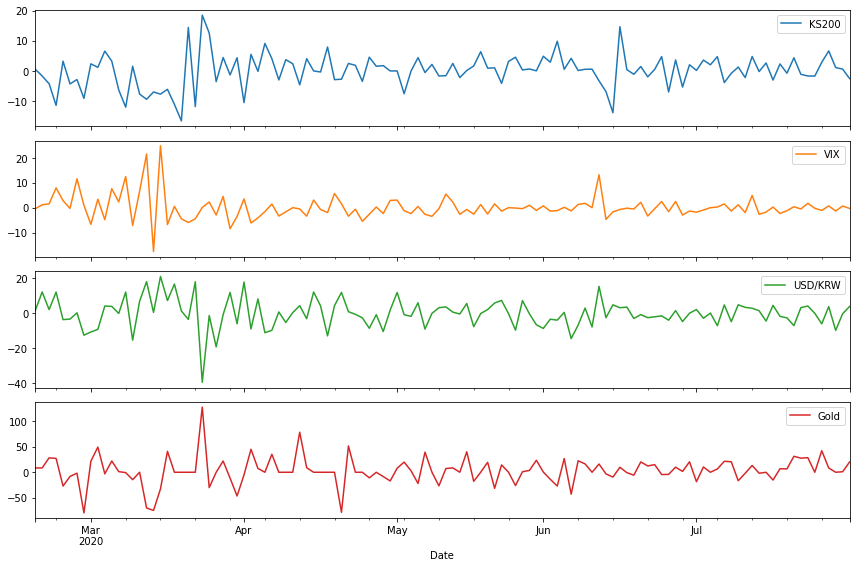

In [23]:
#차분을 이용한 추세제거 
df.diff(1).dropna().plot(subplots=True, figsize=(12,8))
plt.tight_layout()
a = plt.show()

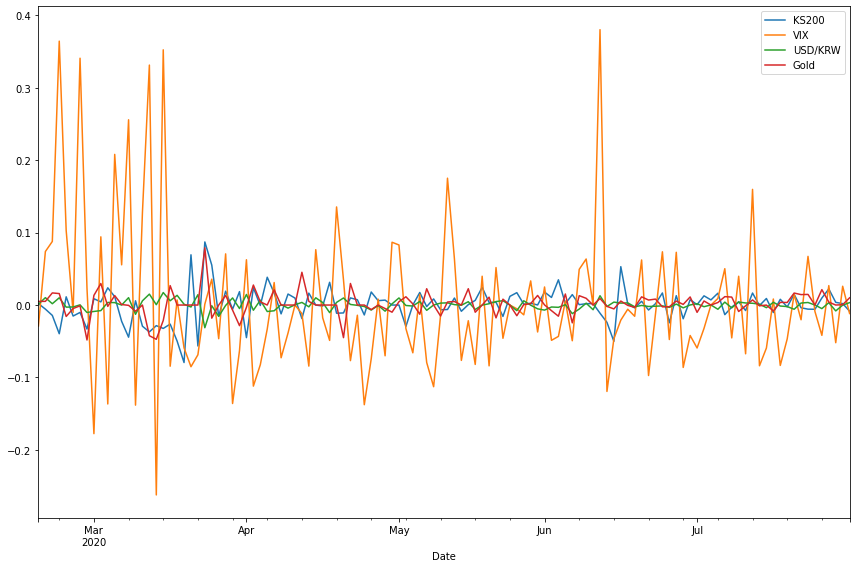

In [24]:
#차분을 이용한 추세제거 
df_log.diff(1).dropna().plot(figsize=(12,8))
plt.tight_layout()
a = plt.show()

In [25]:
# VAR 모형적합
df_use_return = df.diff(1).dropna()
fit = sm.tsa.VAR(df_use_return).fit(maxlags=2) #var2 모형 (2단위시간 전까지 값을 사용, Y_t=A1*Y_t-1+A2*Y_t-2+e_t, k=3)
display(fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, May, 2022
Time:                     15:11:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.5351
Nobs:                     116.000    HQIC:                   17.0275
Log likelihood:          -1589.86    FPE:                1.75720e+07
AIC:                      16.6806    Det(Omega_mle):     1.30320e+07
--------------------------------------------------------------------
Results for equation KS200
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.006380         0.481736            0.013           0.989
L1.KS200          -0.307310         0.108523           -2.832           0.005
L1.VIX            -0.366231         0.114233           -3.206           

In [26]:
# VAR 모형적합
df_use_return = df.diff(1).dropna()
fit = sm.tsa.VAR(df_use_return).fit(maxlags=2) #var2 모형 (2단위시간 전까지 값을 사용, Y_t=A1*Y_t-1+A2*Y_t-2+e_t, k=3)
display(fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, May, 2022
Time:                     15:11:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.5351
Nobs:                     116.000    HQIC:                   17.0275
Log likelihood:          -1589.86    FPE:                1.75720e+07
AIC:                      16.6806    Det(Omega_mle):     1.30320e+07
--------------------------------------------------------------------
Results for equation KS200
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.006380         0.481736            0.013           0.989
L1.KS200          -0.307310         0.108523           -2.832           0.005
L1.VIX            -0.366231         0.114233           -3.206           

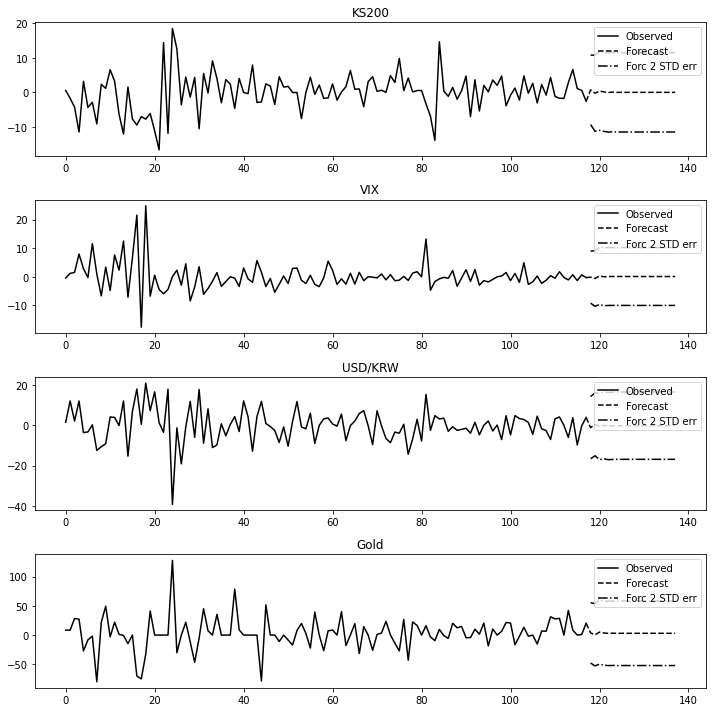

In [27]:
#예측값 확인 
forecast_num = 20
# pred_var = fit.forecast(fit.model.endog[-1:], steps=forecast_num)
# pred_var_ci = fit.forecast_interval(fit.model.endog[-1:], steps=forecast_num)

fit.plot_forecast(forecast_num) 
plt.tight_layout()
plt.show()

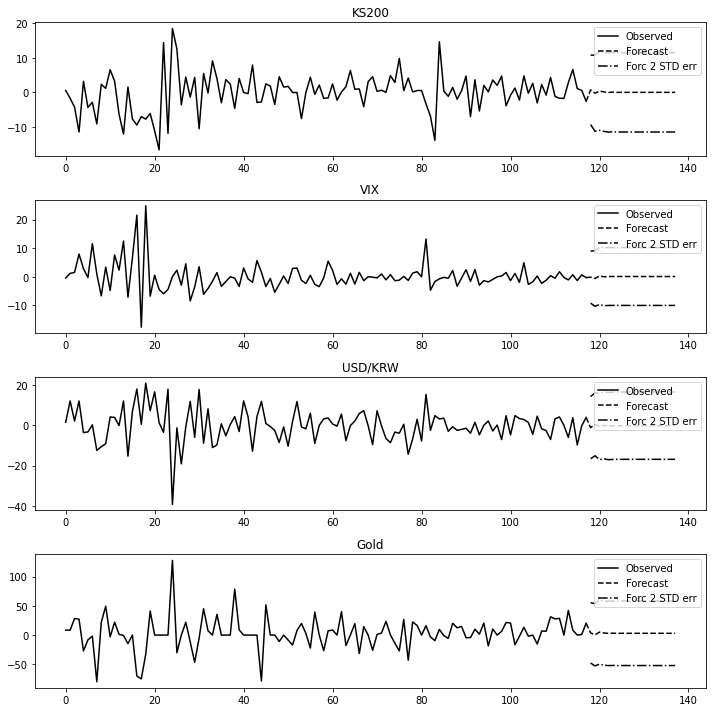

In [28]:
#예측값 확인 
forecast_num = 20
# pred_var = fit.forecast(fit.model.endog[-1:], steps=forecast_num)
# pred_var_ci = fit.forecast_interval(fit.model.endog[-1:], steps=forecast_num)

fit.plot_forecast(forecast_num) 
plt.tight_layout()
plt.show()

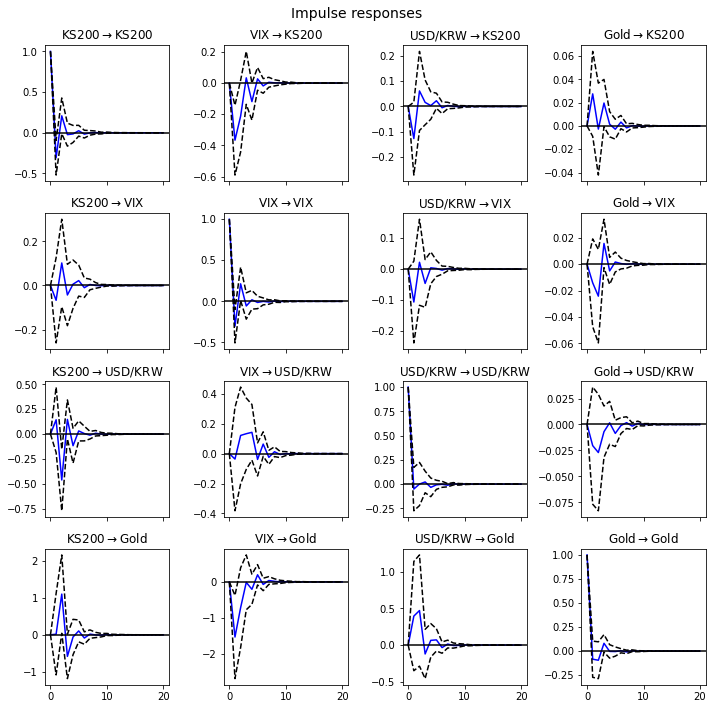

In [29]:
# 임펄스반응함수 추정
fit.irf(forecast_num).plot()
plt.tight_layout()
plt.show()

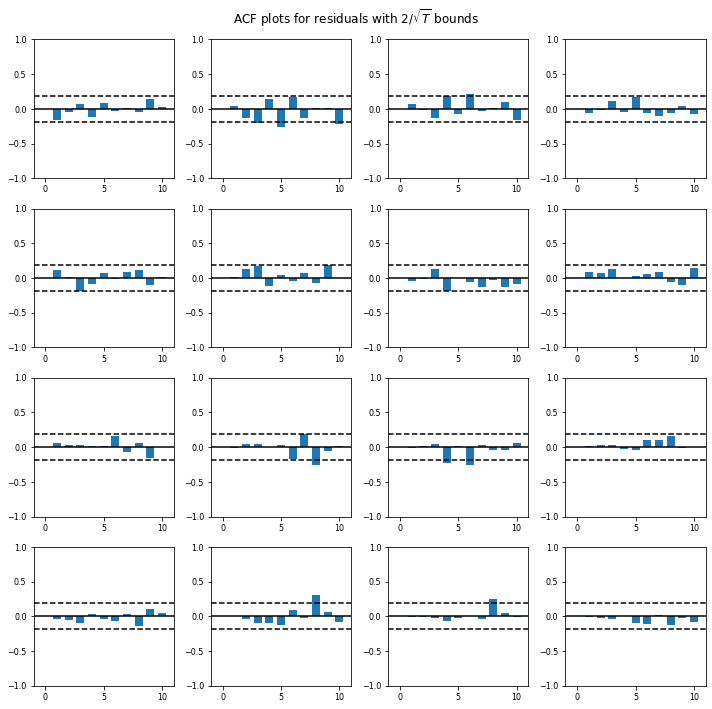

In [30]:
# 잔차진단
fit.plot_acorr()
plt.tight_layout()
plt.show()

In [31]:
# Granger Causality 테스트 (KS200, VIX)

df_ = pd.DataFrame(df[['KS200', 'VIX']])
df_

,KS200,VIX
Date,,
2020-02-18,297.74,14.83
2020-02-19,298.33,14.38
2020-02-20,296.65,15.56
2020-02-21,292.42,17.08
2020-02-24,281.02,25.03
...,...,...
2020-07-27,293.51,24.74
2020-07-28,300.13,25.44
2020-07-29,301.25,24.10


In [32]:
# Granger Causality 테스트 (KS200, VIX)

# 비정상성 차수 추론
target = df_.KS200.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y1_integ_order = 0
if integ_result[1] > 0.1:
    Y1_integ_order = Y1_integ_order + 1
    
target = df_.VIX.copy()
integ_result = pd.Series(sm.tsa.stattools.adfuller(target)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
Y2_integ_order = 0
if integ_result[1] > 0.1:
    Y2_integ_order = Y2_integ_order + 1
print('Y1_order: ', Y1_integ_order, 'Y2_order: ', Y2_integ_order)
# 차분 차수 추론 사용 ( Y1_order: 1 / Y2_order: 1 )
# -> 최소 차분숫자가 각각 1로 나타남

Y1_order:  1 Y2_order:  1


In [33]:
integ_result

Test Statistics       -1.773053
p-value                0.393920
Used Lag               7.000000
Used Observations    111.000000
dtype: float64

In [34]:
# Granger Causality 테스트 (KS200, VIX)

print('\n[VIX -> KS200]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(df_.diff(1).dropna().values, maxlag=4, verbose=True)
print('\n[KS200 -> VIX]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(df_.diff(1).dropna().iloc[:,[1,0]].values, maxlag=4, verbose=True)

# Granger Causality 테스트 기준 (VIX -> KS200 인과성 존재)
# 영향이 없다가 귀무가설


[VIX -> KS200]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0115  , p=0.0157  , df_denom=114, df_num=1
ssr based chi2 test:   chi2=6.1697  , p=0.0130  , df=1
likelihood ratio test: chi2=6.0125  , p=0.0142  , df=1
parameter F test:         F=6.0115  , p=0.0157  , df_denom=114, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.5626 , p=0.0001  , df_denom=111, df_num=2
ssr based chi2 test:   chi2=22.0767 , p=0.0000  , df=2
likelihood ratio test: chi2=20.2094 , p=0.0000  , df=2
parameter F test:         F=10.5626 , p=0.0001  , df_denom=111, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.4433 , p=0.0000  , df_denom=108, df_num=3
ssr based chi2 test:   chi2=49.3327 , p=0.0000  , df=3
likelihood ratio test: chi2=41.0505 , p=0.0000  , df=3
parameter F test:         F=15.4433 , p=0.0000  , df_denom=108, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=12.2